<a href="https://colab.research.google.com/github/PaulToronto/Math-and-Data-Science-Reference/blob/main/Interactive_3D_Plotting_in_Matplotlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive 3D Plotting in Matplotlib

In [1]:
!pip install -q ipympl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget

## Event Handling

[For more details](https://matplotlib.org/stable/users/explain/event_handling.html)

## Event connections

To receive events:

1. Write a callback function
2. Connect your function to the event manager, which is part of the `FigureCanvasBase`

`mpl_connect` returns a connection id (an integer), which can be used to disconnect the callback via `fig.canvas.mpl_disconnect(cid)`

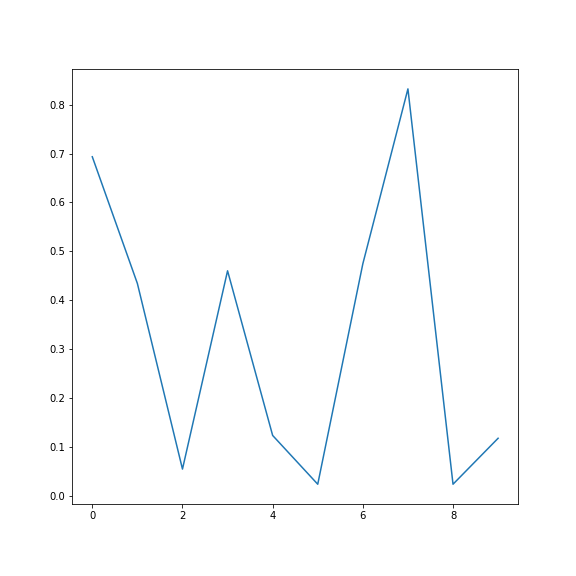

In [3]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))

def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single',
           event.button,
           event.x, 
           event.y,
           event.xdata if event.xdata else -1,
           event.ydata if event.ydata else -1))
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

## List of Events

- 'Event name': `Class`: description
---

- 'button_press_event': `MouseEvent`: mouse button is pressed
- 'button_release_event': `MouseEvent`: mouse button is released
- 'close_event': `CloseEvent`: figure is closed
- 'draw_event': `DrawEvent`: canvas has been drawn (but screen widget not updated yet)
- 'key_press_event': `KeyEvent`: key is pressed
- 'key_release_event': `KeyEvent`: key is released
- 'motion_notify_event': `MouseEvent`: mouse moves
- 'pick_event': `PickEvent`: artist in the canvas is selected
- 'resize_event': `ResizeEvent`: figure canvas is resized
- 'scroll_event': `MouseEvent`: mouse scroll wheel is rolled
- 'figure_enter_event': `LocationEvent`: mouse enters a new figure
- 'figure_leave_event': `LocationEvent`: mouse leaves a figure
- 'axes_enter_event': `LocationEvent`: mouse enters a new axes
- 'axes_leave_event': `LocationEvent`: mouse leaves an axes

## Event attributes

- All `matplotlib` events inherit from the base class `matplotlib.backend_bases.Event`
- as such they have these attributrs
    1. `name`: the event name
    2. `canvas`: the `FigureCanvas` instance generating the event
    3. `guiEvent`: the GUI event that triggered the `matplotlib` event

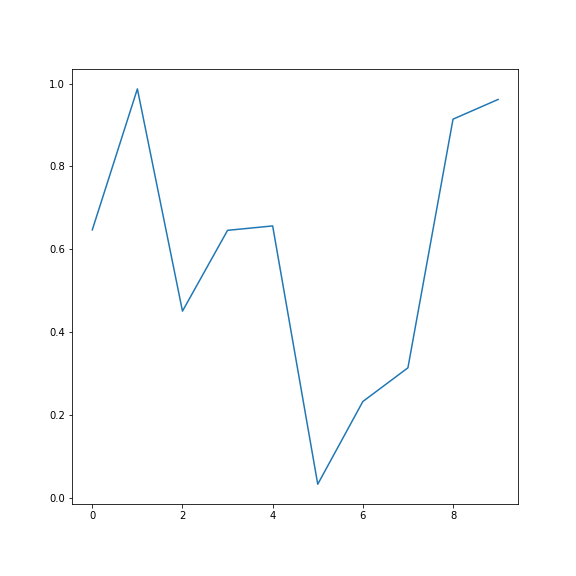

In [4]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))

def onclick(event):
    print(event.name)
    print(type(event.name))
    print('\n--')
    print(event.canvas, type(event.canvas))
    print(type(event.canvas))
    print('\n--')
    print(event.guiEvent)
    print(type(event.guiEvent))
    print('\n--')
    print(event.inaxes)

cid2 = fig.canvas.mpl_connect('button_press_event', onclick)

## Most Common Events

1. `KeyEvent`
    - key_press_event
    - key_release_event
2. `MouseEvent`
    - button_press_event
    - button_release_event
    - motion_notify_event
    - scroll_event

Both of these events are derived from the `LocationEvent` which has the following attributes:

- `x`: mouse x position in pixels from (left, bottom)
- `y`: mouse y position in pixels from (left, bottom)
- `inaxes`: the `Axes` instance over which the mouse is, if any, else `None`
- `xdata`: mouse x position in data coordinates if the mouse is over an axes
- `ydata`: mouse x position in data coordinates if the mouse is over an axes

## Example

- In this canvas, a simple line segment is created every time a mouse is pressed

In [5]:
# this technique is used below
#  to get the element from the list 
#  instead of the list itself
test, = [0]
test

0

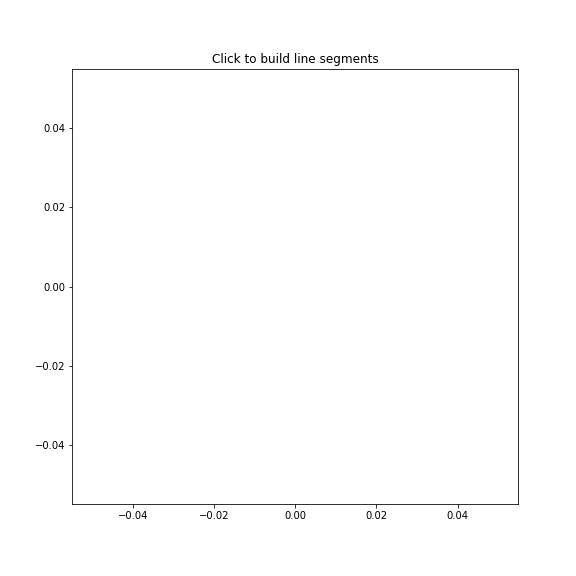

In [6]:
class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.xs = list(line.get_xdata())
        self.ys = list(line.get_ydata())
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        #print('click', event)
        if event.inaxes != self.line.axes:
            return 
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()

        # in addition to those Location event attributes,
        #   the MouseEvent also has access to the button attribute
        #   and key attribute
        print(event.button, event.key)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title('Click to build line segments')
line, = ax.plot([0], [0])
linebuilder = LineBuilder(line)

## Draggable Rectangle Exercise

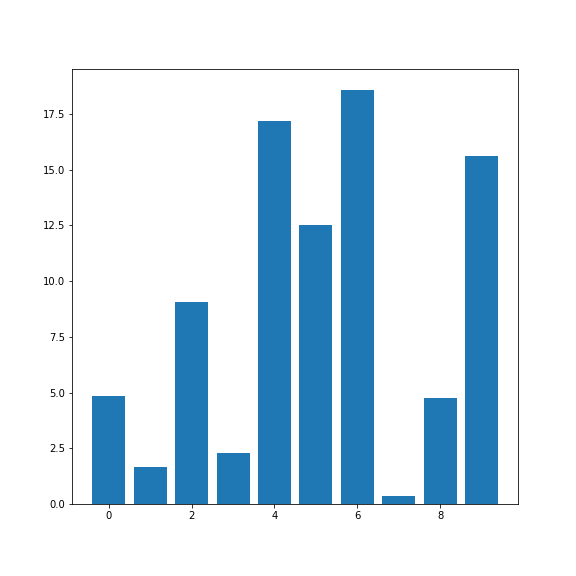

In [7]:
class DraggableRectangle:
    def __init__(self, rect):
        self.rect = rect
        self.press = None

    def connect(self):
        """Connect to all events we need"""
        self.cidpress = self.rect.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.rect.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.rect.figure.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)

    def on_press(self, event):
        if event.inaxes != self.rect.axes:
            return
        contains, attrd = self.rect.contains(event)
        if not contains:
            return
        #print('event contains', self.rect.xy)
        self.press = self.rect.xy, (event.xdata, event.ydata)
        #print(self.press)

    def on_motion(self, event): 
        """Move the rectangle if the mouse is over us"""
        if self.press is None or event.inaxes != self.rect.axes:
            return 
        (x0, y0), (xpress, ypress) = self.press 
        dx = event.xdata - xpress 
        dy = event.ydata - ypress
        self.rect.set_x(x0 + dx)
        self.rect.set_y(y0 + dy)
        self.rect.figure.canvas.draw()

    def on_release(self, event): 
        """Clear button press information"""
        self.press = None 
        self.rect.figure.canvas.draw()

    def disconnect(self):
        """Disconnect all callbacks."""
        self.rect.figure.canvas.mpl_disconnect(self.cidpress)
        self.rect.figure.canvas.mpl_disconnect(self.cidrelease)
        self.rect.figure.canvas.mpl_disconnect(self.cidmotion)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
rects = ax.bar(range(10), 20 * np.random.rand(10))

# Reason for `drs` variable
# The canvas retains only weak references to instance 
# methods used as callbacks. Therefore, you need to 
# retain a reference to instances owning such methods. 
# Otherwise the instance will be garbage-collected 
# and the callback will vanish.
# This does not affect free functions used as callbacks.
drs = []
for rect in rects:
    dr = DraggableRectangle(rect)
    dr.connect()
    drs.append(dr)

plt.show()

## Mouse enter and leave